# Operation

### step 1: First, we gather a set of face images.  The faces must be frontal, aligned and cropped to the face region.  They must capture sufficient lighting variations for each face.

### step 2: Convert to grayscale and normalize by dividing each pixel by 255.  

### step 3: Then subtract the mean face (calculated for the dataset).

### step 4: Calculate covariance matrix for the training set.

### step 5: Learn the feature extractor:  Calculate eigenvalues and eigenvectors of the covariance matrix - eigenvectors are the orthonormal basis i.e. these are the principal components that define the face space.

#### Reference: https://www.baseapp.com/computer-vision/a-comprehensive-guide-to-facial-recognition-algorithms/

# we are currently executing step 3

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import pickle

In [3]:
#load the data from pickle

data = pickle.load(open('./data/data_images_100_100.pickle', mode ='rb'))

In [4]:
data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_9991,pixel_9992,pixel_9993,pixel_9994,pixel_9995,pixel_9996,pixel_9997,pixel_9998,pixel_9999,gender
0,0.784314,0.741176,0.737255,0.709804,0.721569,0.725490,0.701961,0.690196,0.741176,0.705882,...,0.415686,0.423529,0.435294,0.443137,0.450980,0.470588,0.458824,0.462745,0.478431,female
1,0.121569,0.098039,0.137255,0.098039,0.121569,0.113725,0.117647,0.121569,0.133333,0.133333,...,0.105882,0.086275,0.117647,0.086275,0.137255,0.078431,0.137255,0.254902,0.074510,female
2,0.192157,0.192157,0.137255,0.133333,0.164706,0.156863,0.137255,0.152941,0.278431,0.243137,...,0.901961,0.905882,0.929412,0.933333,0.901961,0.862745,0.831373,0.823529,0.815686,female
3,0.537255,0.501961,0.447059,0.376471,0.376471,0.372549,0.364706,0.447059,0.588235,0.639216,...,0.207843,0.266667,0.262745,0.290196,0.360784,0.380392,0.403922,0.400000,0.376471,female
4,0.917647,0.925490,0.905882,0.905882,0.905882,0.725490,0.556863,0.435294,0.203922,0.176471,...,0.941176,0.925490,0.929412,0.937255,0.929412,0.929412,0.949020,0.945098,0.945098,female


In [5]:
#drop the independent column - 'gender'

X = data.drop('gender', axis = 1).values
X.shape

(4319, 10000)

## Mean face

In [6]:
mean_face = X.mean(axis = 0)  #extracting already flattened, mean face

mean_face.shape


(10000,)

In [7]:
mean_face

array([0.37237015, 0.36976333, 0.36578729, ..., 0.3797139 , 0.37925355,
       0.38073537])

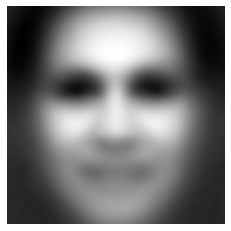

In [8]:
#visualizing mean face

plt.imshow(mean_face.reshape((100,100)), cmap = 'gray')
plt.axis('off')
plt.show()

In [9]:
#subtract  mean face from data

X_t = X - mean_face

## Apply X_t data to PCA
### Step 1: find right number of components using elbow method
### Step 2: with right number of components computer PCA

In [10]:
pca = PCA(n_components = None, whiten = True, svd_solver = 'auto')    #ref: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
pca.fit(X_t)

PCA(whiten=True)

### whiten bool, default=False
##### When True (False by default) the components_ vectors are multiplied by the square root of n_samples and then divided by the singular values to ensure uncorrelated outputs with unit component-wise variances.

##### Whitening will remove some information from the transformed signal (the relative variance scales of the components) but can sometime improve the predictive accuracy of the downstream estimators by making their data respect some hard-wired assumptions.

In [15]:
expvar_df = pd.DataFrame()
expvar_df['explained_variance'] = pca.explained_variance_ratio_
expvar_df['cumulative_exp_var'] = expvar_df['explained_variance'].cumsum()
expvar_df['principal_components'] = np.arange(1, len(expvar_df)+1)
expvar_df.head()

,explained_variance,cumulative_exp_var,principal_components
0,0.251699,0.251699,1
1,0.114162,0.365860,2
2,0.105622,0.471482,3
3,0.051887,0.523369,4
4,0.033064,0.556433,5


## Visualize elbow plot

In [16]:
expvar_df.set_index('principal_components', inplace = True)


<AxesSubplot:xlabel='principal_components'>

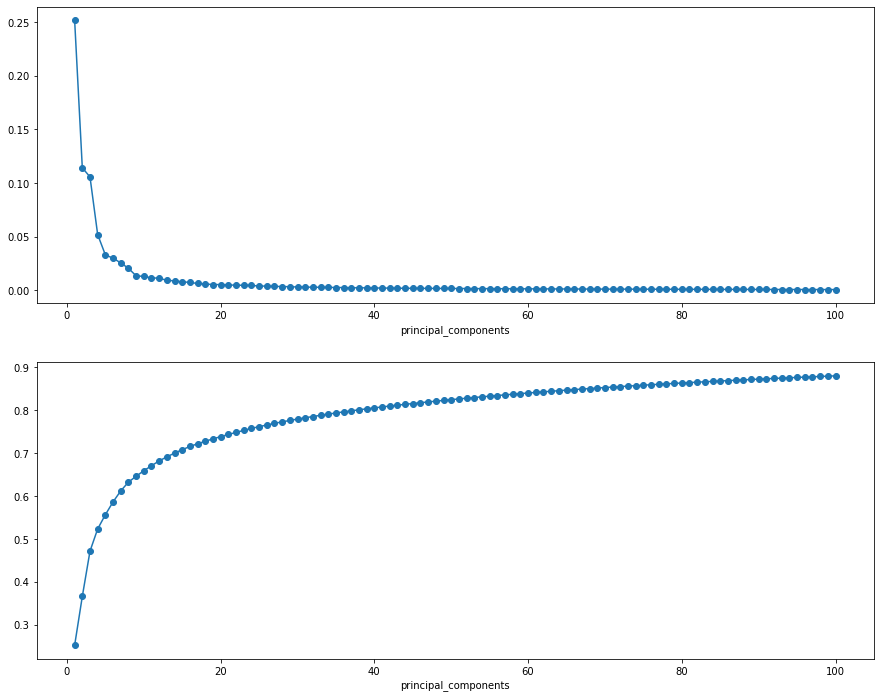

In [19]:
fig, ax = plt.subplots(nrows = 2, figsize = (15,12))
expvar_df['explained_variance'].head(100).plot(kind = 'line', marker = 'o', ax = ax[0])
expvar_df['cumulative_exp_var'].head(100).plot(kind = 'line', marker = 'o', ax = ax[1])

### we need to consider atleast 80 % of cum_explained variance of PCA, which comes out to be 50 principal components

In [20]:

pca_50 = PCA(n_components = 50, whiten = True, svd_solver = 'auto') 
pca_data = pca_50.fit_transform(X_t)

In [22]:
pca_data.shape

(4319, 50)

# Saving the data 

In [23]:
y = data['gender'].values

In [24]:
y

array(['female', 'female', 'female', ..., 'male', 'male', 'male'],
      dtype=object)

In [26]:
np.savez('./data/pri_data_pca_50_target', pca_data, y)  #saving data using numpy zip

In [27]:
pca_dict = {'pca':pca_50, 'mean_face':mean_face}

In [29]:
pickle.dump(pca_dict, open('model/pri_pca_dict.pickle', 'wb'))

# Visualizing eigen face

In [49]:
pca_data_inv = pca_50.inverse_transform(pca_data)

In [50]:
pca_data_inv.shape

(4319, 10000)

In [51]:
pca_data_inv

array([[ 0.26929735,  0.28416296,  0.29406689, ...,  0.01407684,
         0.01396211,  0.01179157],
       [-0.29446362, -0.29597865, -0.29242685, ..., -0.3151831 ,
        -0.32879112, -0.34081237],
       [-0.22357374, -0.22804018, -0.22223269, ...,  0.09098339,
         0.09947674,  0.09388904],
       ...,
       [ 0.24504923,  0.26331524,  0.291125  , ...,  0.25577021,
         0.25690848,  0.26877452],
       [-0.24647126, -0.24409482, -0.24119277, ..., -0.20438209,
        -0.21021245, -0.21618062],
       [ 0.39060658,  0.38816209,  0.39644489, ...,  0.35671909,
         0.3618661 ,  0.35232065]])

In [52]:
eigen_img = pca_data_inv[0, :].reshape((100,100))

In [53]:
eigen_img.shape

(100, 100)

(-0.5, 99.5, 99.5, -0.5)

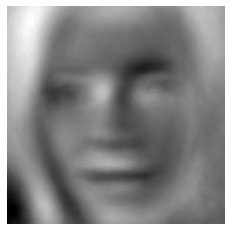

In [54]:
plt.imshow(eigen_img, cmap = 'gray')
plt.axis('off')

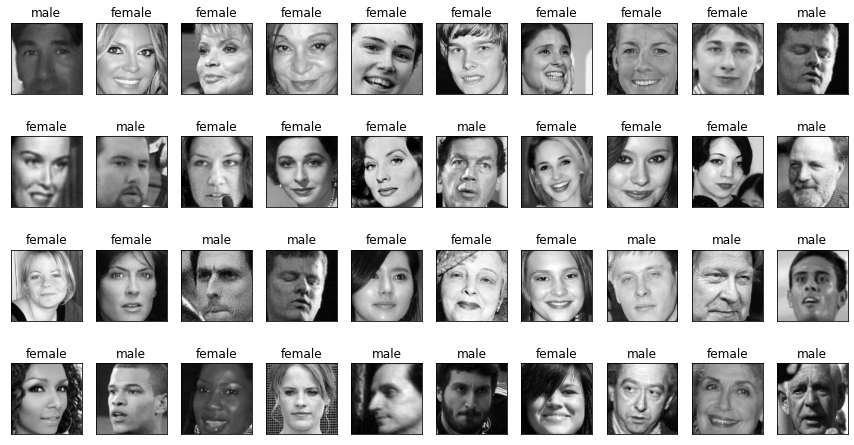

====================Eigen Images====================


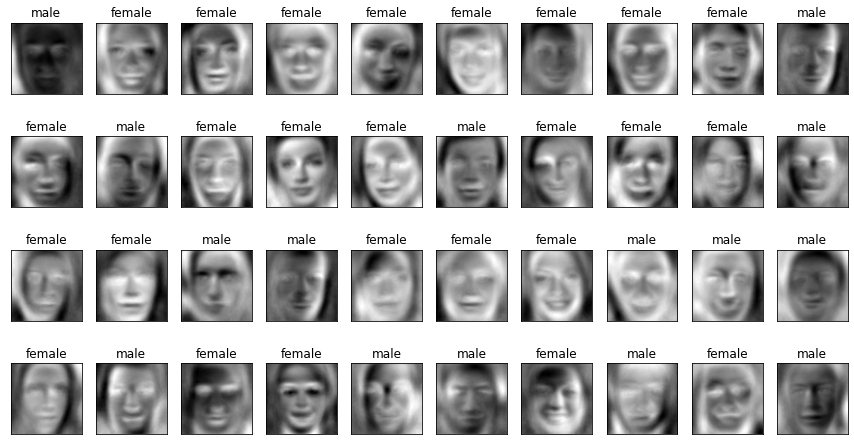

In [55]:
#plotting eigen faces for random images
np.random.seed(1001)
pics = np.random.randint(0,4319,40)
plt.figure(figsize=(15,8))
for i,pic in enumerate(pics):
    plt.subplot(4,10,i+1)
    img = X[pic:pic+1].reshape(100,100)
    plt.imshow(img,cmap='gray')
    plt.title('{}'.format(y[pic]))
    plt.xticks([])
    plt.yticks([])
plt.show()

print("="*20+'Eigen Images'+"="*20)
plt.figure(figsize=(15,8))
for i,pic in enumerate(pics):
    plt.subplot(4,10,i+1)
    img = pca_data_inv[pic:pic+1].reshape(100,100)
    plt.imshow(img,cmap='gray')
    plt.title('{}'.format(y[pic]))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

# End